In [1]:
import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import ArmActionMode, JointVelocity, JointPosition, EndEffectorPoseViaPlanning, EndEffectorPoseViaIK


from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig, CameraConfig
# from rlbench.tasks.pick_described_object import PickDescribedObject
from rlbench.tasks import PutGroceriesInCupboard, PickAndLift, StackBlocks, PlaceHangerOnRack, PickDescribedObject, TakeLidOffSaucepan, SetTheTable
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt


class Agent(object):
    def __init__(self, action_shape):
        self.action_shape = action_shape

    def act(self, obs):
        xyz = np.array([2.78478146e-01, -8.15162994e-03,  1.47194254e+00])
        rot = np.array([-3.14, 0.24243259,  3.14])
        #rot to quat
        quat = R.from_euler('xyz', rot).as_quat()
        gripper = [1.0]
        return np.concatenate([xyz,quat, gripper], axis=-1)


In [2]:
camera = CameraConfig(image_size=(224, 224), depth=False, point_cloud=False, mask=False)
obs_config = ObservationConfig(left_shoulder_camera=camera, right_shoulder_camera=camera, front_camera=camera, overhead_camera=camera)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True, collision_checking=True), gripper_action_mode=Discrete()),
    obs_config=obs_config,
    headless=False)
env.launch()



In [62]:
target_item_poses = []
waypoints = []
gripper_poses = []
front_rgbs = []
def callable_fun(obs, task, variation_num):
    # target item pose
    target_item_pose = task._task.get_graspable_objects()[variation_num].get_pose()
    target_item_pose = np.concatenate([target_item_pose[:3], R.from_quat(target_item_pose[3:]).as_euler('xyz')])
    target_item_poses.append(target_item_pose)

    #waypoints
    current_pose = np.array(obs.gripper_pose)
    current_pose = np.concatenate([current_pose[:3], R.from_quat(current_pose[3:]).as_euler('xyz')])
    gripper_poses.append(current_pose)
    wps = [wp._waypoint.get_position() for wp in task._task._waypoints]
    
    if abs(current_pose[:3] - wps[0]).mean() < 1e-2:
        waypoints.append(0)
    elif abs(current_pose[:3] - wps[1]).mean() < 1e-2:
        waypoints.append(1)
    elif abs(current_pose[:3] - wps[2]).mean() < 1e-2:
        waypoints.append(2)
    else:
        waypoints.append(-1)

    #front rgb
    front_rgbs.append(obs.front_rgb)
    

variation_num = 1
task = env.get_task(PickDescribedObject)
task.set_variation(variation_num)

demos = task.get_demos(1, live_demos=True, callable_each_step=lambda x: callable_fun(x,task=task, variation_num=variation_num)) 
basket_position = task._task.dropin_box.get_position()
# demos = np.array(demos).flatten()
# descriptions, obs = task.reset() 

In [69]:
waypoints.index(2)

198

In [53]:
task._task._waypoints[0]._waypoint.get_pose()

array([ 3.22548747e-01,  1.10074833e-01,  8.24993849e-01, -1.66194528e-01,
       -9.86092985e-01, -1.77989335e-04,  1.81580181e-05])

In [51]:
task._task.grasp_points[0].get_pose()

array([ 1.04694076e-01, -1.34871051e-01,  8.24995041e-01, -7.08412409e-01,
       -7.05798745e-01, -9.15655528e-06, -9.35975368e-06])

In [50]:
task._task.get_graspable_objects()[0].get_pose()

array([ 1.04602322e-01, -1.59870893e-01,  7.99995065e-01, -9.98937821e-08,
       -1.30509416e-05, -1.84817833e-03,  9.99998331e-01])

In [43]:
waypoints

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 2,
 2,
 2]

In [15]:
l = [np.array([1]), np.array([2.88887878e-1]), np.array([3])]
l.index(np.array([2.8888788e-1]))

ValueError: array([0.28888788]) is not in list

In [22]:
task._task.get_waypoints()[0]

array([ 2.12069944e-01, -3.12024176e-01,  8.24993849e-01,  9.86910880e-01,
       -1.61266774e-01,  4.49348008e-05,  1.73798602e-04])

In [9]:
basket_position

[array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993, -0.32499993,  1.        ]),
 array([-0.19999993,

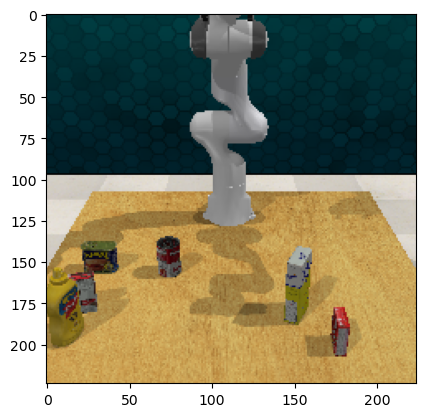

In [4]:
plt.imshow(obs.front_rgb)

In [30]:
task._task._waypoints[4]._robot.gripper.get_open_amount()

# robot.gripper.get_open_amount()

[1.0, 1.0]

In [ ]:
task._task.robot.gripper

In [6]:
task._task._waypoints[0].get_waypoint_object().get_pose()
task.step(np.concatenate([task._task._waypoints[0].get_waypoint_object().get_pose(),[1]]))

(<rlbench.backend.observation.Observation at 0x7fa0a5d9d150>, 0.0, False)

In [74]:
task.step(np.concatenate([task._task.target_block.get_pose(),[0]]))

(<rlbench.backend.observation.Observation at 0x7d01e17c2310>, 0.0, False)

In [ ]:
task.step(np.concatenate([task._task.target_block.get_pose(),[0]]))

In [58]:
# task._task.distractors[0].get_pose()
task.step(np.concatenate([task._task.distractors[0].get_pose(),[0]]))

InvalidActionError: A path could not be found. Most likely due to the target being inaccessible or a collison was detected.

In [ ]:
task._task.__dict__

In [48]:
task._task._graspable_objects[0].get_pose()

array([ 3.63413215e-01, -2.43198574e-02,  7.75002122e-01,  6.15314484e-01,
        7.88281679e-01,  7.99439749e-06,  1.03862631e-05])

In [51]:
task._task.target_block.get_pose()

array([ 3.63413215e-01, -2.43198574e-02,  7.75002122e-01,  6.15314484e-01,
        7.88281679e-01,  7.99439749e-06,  1.03862631e-05])

In [ ]:
task._task.get_graspable_objects()[0].get_position()

array([ 0.1119114 , -0.22405708,  0.77499521])

In [ ]:
task._task.get_graspable_objects()[0].get_position()

In [ ]:
task = env.get_task(PickAndLift)

agent = Agent(env.action_shape)
training_steps = 120
episode_length = 40
obs = None
for i in range(training_steps):
    # if i % episode_length == 0:
    print("Reset Episode")
    descriptions, obs = task.reset()
    print(descriptions)
    item_name = task._task.item_name
    item_coord = task._task.item.get_position()
    item_orientation = task._task.item.get_orientation()
    print(item_name)
    print(item_coord)
    print(item_orientation)
    action = agent.act(obs)
    obs, reward, terminate = task.step(action)
    print(reward)
    break


Reset Episode
['pick up the red block and lift it up to the target', 'grasp the red block to the target', 'lift the red block up to the target']


AttributeError: 'PickAndLift' object has no attribute 'item_name'

In [ ]:
task._task.get_waypoints()[0].get_waypoint_object().get_position()

array([ 0.13631016, -0.06427181,  1.20000005])

In [70]:

print("Done")
env.shutdown()

Done
[CoppeliaSim:loadinfo]   done.
